# Adding bulk data

Say we wish to create a large quantity of bulk training data, and then store this in an intelligible and consistent format. Well, that's where heron's training data interface comes along.

I'll make use of the pycbc waveform interface in order to generate training data from some of the pre-existing approximant models just so that we have access to a reasonably controlable data source. However the same principles could be used to work with numerical relativity data, though the individual waveform interface may be an easier way to do that.

In [1]:
import pycbc.waveform
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from pycbc.waveform import get_td_waveform
qs = np.linspace(0.1, 1.0, 40)
#qs=[0.75]
waveforms = {}
for q in qs:
    waveforms[q] = {}
    unaligned = {}
    
    apx = "IMRPhenomPv2"
    
    M = 20
    m1 = M / (1+q)
    m2 = M / (1+1/q)
    assert ((m1 + m2) - M ) < 1e-4
    waveforms[q][apx] = {}

    unaligned[apx] = {}
    unaligned[apx]['hp'], unaligned[apx]['hc'] = get_td_waveform(approximant=apx,
                                 mass1=m1,
                                 mass2=m2,
                                 spin1z=0,
                                 delta_t=1.0/4096,
                                 f_lower=20)
    waveforms[q]['IMRPhenomPv2']['hp'], waveforms[q]['IMRPhenomPv2']['hc'] = unaligned[apx]['hp'], unaligned[apx]['hc']
    #waveforms[q]['IMRPhenomPv2']['hp'], waveforms[q]['SEOBNRv2']['hp'] = pycbc.waveform.coalign_waveforms(unaligned['IMRPhenomPv2']['hp'], unaligned['SEOBNRv2']['hp'])
    #waveforms[q]['IMRPhenomPv2']['hc'], waveforms[q]['SEOBNRv2']['hc'] = pycbc.waveform.coalign_waveforms(unaligned['IMRPhenomPv2']['hc'], unaligned['SEOBNRv2']['hc'])

In [3]:
data_all = []
for mass_ratio, waveform in waveforms.items():
    for approx, waveform_a in waveform.items():
        idx = (waveform_a['hp'].sample_times > -0.05) & (waveform_a['hp'].sample_times < 0.02)
        data = np.ones((5, len(waveform_a['hp'].data[idx])))
        data[0, :] *= mass_ratio
        data[1, :] *= 0 if approx == "IMRPhenomPv2" else 1
        data[2, :] = waveform_a['hp'].sample_times[idx]
        data[3, :] = waveform_a['hp'].data[idx]
        data[4, :] = waveform_a['hc'].data[idx]
        data_all.append(data)
input_data = np.hstack(data_all)

In [4]:
from heron.data import DataWrapper

First we need to make the data file; this is implemented as a class method, so we just need to run `DataWrapper.create()`.

In [5]:
! rm test_file.h5

In [6]:
data = DataWrapper.create("test_file.h5")

We can then add all of the data, specifying what the columns are, and which polarisation we're adding.

In [7]:
data.add_data(group="mixed_model",
              polarisation='+',
              reference_mass=20,
                source="IMRPhenomXPHM",
                parameters=["time", "mass ratio"],
                locations=input_data[[2, 0]].T,
                data=input_data[3])

# Adding individual waveforms

Most of the time we'll in fact want to add individual waveforms one at a time to the data collection, since that's how we normally generate them. We can use the `add_waveform` method to do this.

In [8]:
! rm test_file_2.h5

In [9]:
from heron.data import DataWrapper

In [10]:
data = DataWrapper.create("test_file_2.h5")

In [11]:
from pycbc.waveform import get_td_waveform
qs = np.linspace(0.1, 1.0, 20)

q = 1.0
apx = "IMRPhenomPv2"
    
M = 20
m1 = M / (1+q)
m2 = M / (1+1/q)
assert ((m1 + m2) - M ) < 1e-4

hp, hc = get_td_waveform(approximant=apx,
                             mass1=m1,
                             mass2=m2,
                             spin1z=0,
                             delta_t=1.0/4096,
                             f_lower=20)  

In [12]:
idx = (hp.sample_times > -0.05) & (hp.sample_times < 0.02)

In [13]:
inspiral = (hp.sample_times > -0.15) & (hp.sample_times < -0.005)
merger = (hp.sample_times >= -0.0075) & (hp.sample_times < 0.005)
new_times = np.hstack([hp.sample_times[inspiral][::5], hp.sample_times[merger]])
new_strain = np.hstack([hp[inspiral][::5], hp[merger]])
data.add_waveform(group="IMR training simple",
                  polarisation="+",
                  reference_mass=M,
                  source=apx,
                  locations={"mass ratio": q},
                  times=new_times,
                  data=new_strain
                 )

We could then repeat this in a loop to add the data in a more straight-forward manner than is possible with the batch interface.

In [14]:
from pycbc.waveform import get_td_waveform
qs = np.logspace(np.log(0.1), 0, 15)
apx = "IMRPhenomPv2"
M = 20

for q in qs:

    m1 = M / (1+q)
    m2 = M / (1+1/q)
    assert ((m1 + m2) - M ) < 1e-4

    hp, hc = get_td_waveform(approximant=apx,
                                 mass1=m1,
                                 mass2=m2,
                                 spin1z=0,
                                 delta_t=1.0/4096,
                                 f_lower=20)
    
    idx = (hp.sample_times > -0.05) & (hp.sample_times < 0.02)
    inspiral = (hp.sample_times > -0.15) & (hp.sample_times < -0.005)
    merger = (hp.sample_times >= -0.0075) & (hp.sample_times < 0.005)
    new_times = np.hstack([hp.sample_times[inspiral][::5], hp.sample_times[merger]])
    new_strain = np.hstack([hp[inspiral][::5], hp[merger]])
    data.add_waveform(group="IMR training",
                  polarisation="+",
                  reference_mass=M,
                  source=apx,
                  locations={"mass ratio": q},
                  times=new_times,
                  data=new_strain
                 )

# Plotting the training data

It can be helpful to examine the training data visually, and to allow this the interface provides a quick way to produce a scatter plot of the contents of a dataset.

In [15]:
data = DataWrapper("test_file_2.h5")

findfont: Font family ["'URW Bookman L'"] not found. Falling back to DejaVu Sans.


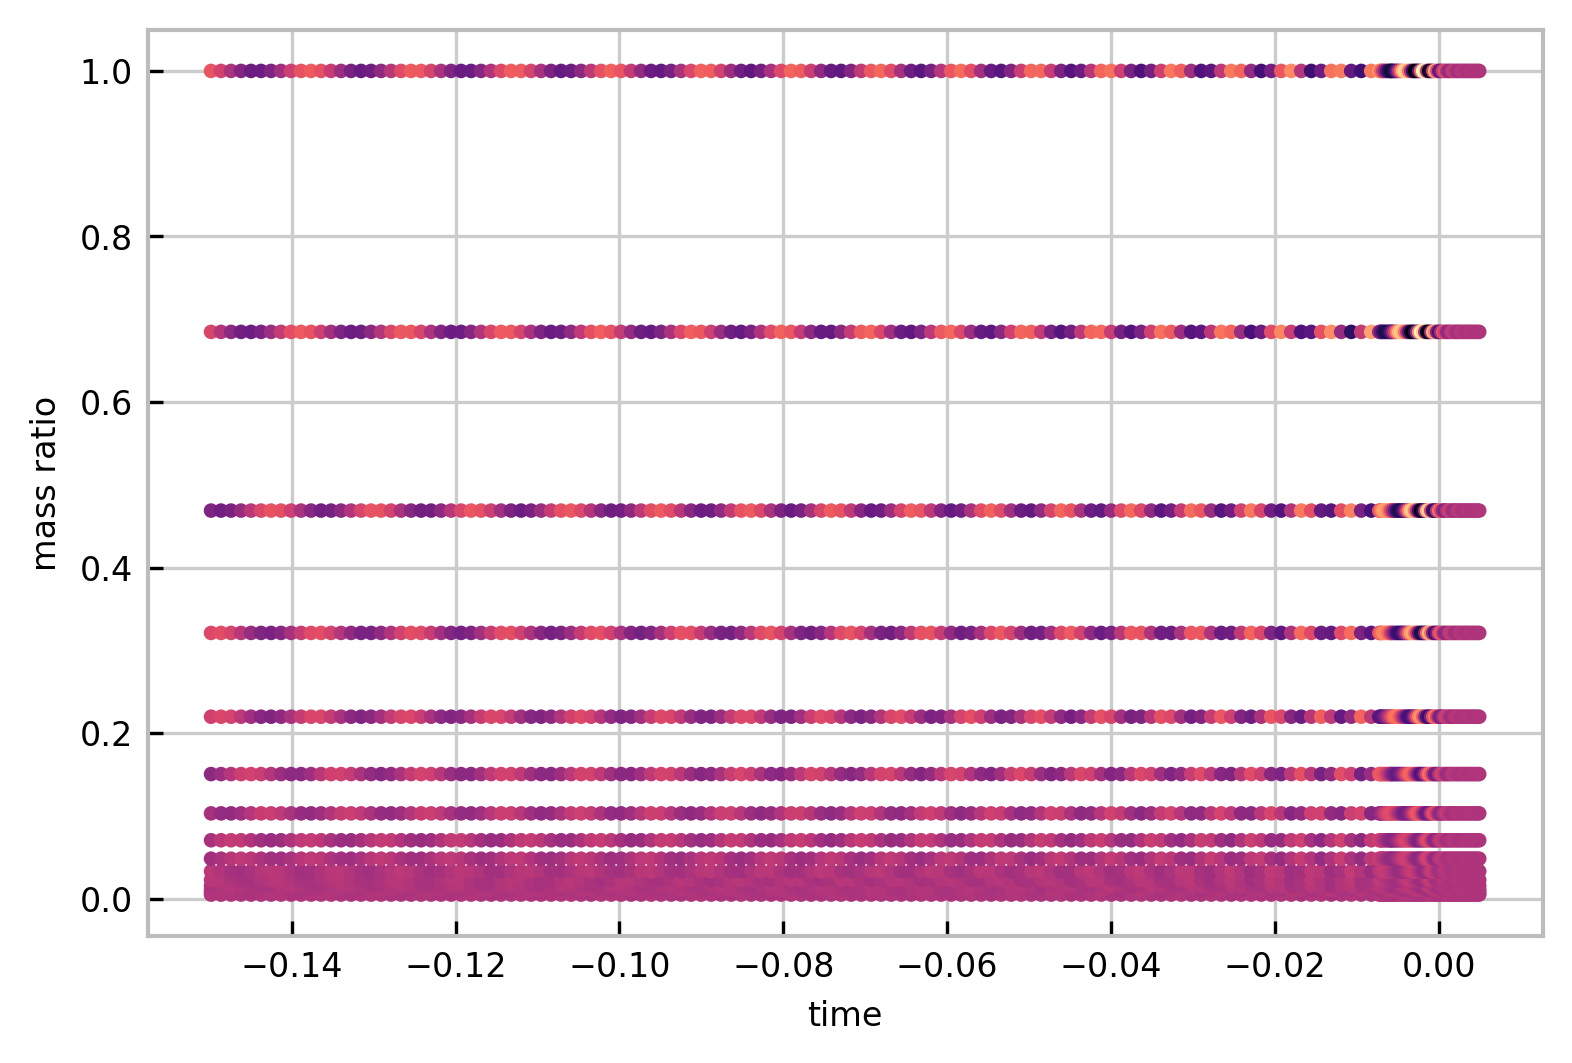

In [16]:
fig = data.plot_surface(label="IMR training", x="time", y="mass ratio", polarisation=b"+", decimation=1);

In [17]:
fig.savefig("tutorial-training-scatter.png")